# Project 1
Scrape and compute field_field_influence matrix described below. Display as directed graph using networkx package.

## Notation
- $a$ = number of unique authors
- $f$ = number of unique fields
field[q]
- Credit Matrix $C$
  - $a \times f$ matrix $C$ initialized with zeros
  - Each paper's field is given in its ArXiV record.
  - If a paper has $k$ authors, each author receives $\frac{1}{k}$ credit in that paper's field.
  - $C_{ij}$ = total credit for author $i$ in field $j$
  - Process:
      - for paper in ArXiV:
          - for auth in authors:
              - C\[auth, field\] += $\frac{1}{k}$
- Author Activity Matrix $A$
  - $a \times f$ matrix $A$ initialized as a copy of $C$
  - Divide by row sums: $A$ = make_stochastic($C$, axis=1)
  - $A_{ij}$ = proportion of all credit earned by author $i$ that comes from papers in field $j$ = proportion of author $i$ that "belongs" to field $j$
- Importance Matrix $I$
  - $a \times f$ matrix $I$ initialized as copy of $C$
  - Divide by columns sums: $I$ = make_stochastic($C$, axis=0)
  - $I_{ij}$ = proportion of all credit in field $j$ earned by author $i$ = importance of author $i$ in field $j$
- Field-Field Influence Matrix $B$
  - $f \times f$ matrix $B = A^T I$
  - $B_{ij}$ = influence by field $i$ on field $j$ = proportion of all credit in field $j$ attributable to field $i$.
  - $B_{ij} = \sum_k A^T_{ik} I_{kj} = \sum_k A_{ki} I_{kj} = \sum_k (\mbox{activity of author k in field i}) \cdot (\mbox{importance of author k in field j}) = \sum_k (\mbox{proportion of author k that "belongs" to field i}) \cdot (\mbox{importance of author k in field j})$




# Project 2 - Optimize funding using gradient descent


## Notation
- Use use $*$ to denote entry-wise multiplication that uses broadcasting rules.  This will distinguish from regular matrix multiplication.  Similarly, $/$ denotes entry-wise multiplication by the reciprocal of the second factor.

- Field Funding Vector $\$F$
  - $f$ vector whose entries sum to $1$
  - $\$F_i$ = proportion of all science funding currently going to field $i$
- Author Funding Vector $\$A$
  - $a$ vector $\$A = I\$F$
  - $\$A_i = \sum_j I_{ij} \$F_j$
  - Field $j$ distributes its funds $F_j$ to authors in proportion to their importance in that field.
  - An authors funding is the total of her funding from all fields
- Author Productivity
  - $a \times f$ matrix $P$
  - $P_{ij} = C_{ij} / \$A_i$ = credit by author $i$ in field $j$ per unit of funding
  - ASSUME this matrix is invariant - it is intrinsic to the author

Process:
0. Scrape ArXiV, compute $C$, $A$, $I$, $W$, $B$
1. Choose initial field funding Vector $\$F$.
2. Compute:
  - $\$A = I\$F$
  - $P = C / \$A$  (Note: This is entry-wise multiplication by the reciprocal.  This uses broadcasting rules.)  Assume $P$ does not vary.
3. Iterate the following system
  - Compute author funding $\$A = I\$F$
  - Compute new credit matrix $C = P * \$A$
  - Compute new importance matrix $I$
  - Compute new field funding vector using gradient descent
    - $C_{ij} = P_{ij} \$A_i = P_{ij} \sum_k I_{ik} \$F_k$
    - $\frac{\partial C_{ij}}{\partial \$F_k} = P_{ij} I_{ik}$
    - $C = \sum_{ij} C_{ij}$
    - $\frac{\partial C}{\partial \$F_k} = \sum_{ij} \frac{\partial C_{ij}}{\partial \$F_k} = \sum_{ij} P_{ij} I_{ik}$
    - $\nabla C = \langle \frac{\partial C}{\partial \$F_1}, \frac{\partial C}{\partial \$F_2}, \dots, \frac{\partial C}{\partial \$F_f} \rangle = I^T P 1_f$ where $1_f$ is an $f$-vectors of 1's.
    - $\$F_{new} = \$F_{old} + \frac{\nabla C}{||\nabla C||} \cdot \mbox{learning rate}$
4. This result will depend upon the chosen initial field funding vector.  Ideally, we will find some resource that gives a rough idea of the current real world funding.
  
  


In [1]:
%%time
%run -i setup.py
import string

sample_prop = 1.0

def make_stochastic(A, axis=0):
    A[A<0] = 0.0
    s = np.sum(A, axis=axis, keepdims=True)
    s[np.isclose(s,0.0)] = 1.0
    return A / s

# Download and import data
download = False # If download is true download and save data, else just read data
if(download):
    ## Data set
    data_url = "https://www.dropbox.com/s/mxlqmphe9dxtw8y/data_v3.csv?dl=1"
    df = pd.read_csv(data_url)
    df.to_csv("data.csv", index = False)
else:
    df = pd.read_csv("data.csv")
print(df.shape)

# Cleaning the dataframe
df.dropna(inplace = True)
print(df.shape)
df.drop_duplicates(subset = "title", keep = "last", inplace = True)
try:
    df.drop("Unnamed: 0", axis = 1, inplace = True) # Drop the "Unnamed: 0"
except:
    pass
print(df.shape)


num_papers = df.shape[0]
sample_size = int(sample_prop*num_papers)
sample = np.random.choice(np.arange(num_papers), sample_size, replace=False)
df = df.iloc[sample]

table = str.maketrans('', '', string.punctuation)
def clean(s):
    return s.lower().translate(table).strip()

all_auths = set()
for new_auths in df['authors'].tolist():
    all_auths.update((clean(name) for name in new_auths.split(';')))

all_auths = sorted(list(all_auths))
all_fields = sorted(list(set(df['category'].tolist())))

auth_dict = {auth:index for (index, auth) in enumerate(all_auths)}
field_dict = {field:index for (index, field) in enumerate(all_fields)}

# Creating the credit matrix
num_auths = len(all_auths)
num_fields = len(all_fields)
credit_orig = np.zeros((num_auths, num_fields), dtype=float)

for idx, (authors, field) in df[['authors','category']].iterrows():
    auths = [clean(name) for name in authors.split(";")]
    contribute = 1.0 / len(auths)
    for auth in auths:
        try:
            credit_orig[auth_dict[auth], field_dict[field]] += contribute
        except KeyError as e:
            print(e)

credit = credit_orig.copy()
activity = make_stochastic(credit, axis=1)
importance = make_stochastic(credit, axis=0)
influence = activity.T.dot(importance)
influence = pd.DataFrame(influence, index=all_fields, columns=all_fields)
display(margins(influence))

(2098183, 6)
(2098180, 6)
(1319569, 5)


,cs,econ,eess,math,physics:astro-ph,physics:cond-mat,physics:gr-qc,physics:hep-ex,physics:hep-lat,physics:hep-ph,...,physics:math-ph,physics:nlin,physics:nucl-ex,physics:nucl-th,physics:physics,physics:quant-ph,q-bio,q-fin,stat,TOTAL
cs,0.842,0.039,0.191,0.022,0.002,0.005,0.003,0.002,0.002,0.002,...,0.004,0.014,0.003,0.003,0.017,0.008,0.031,0.023,0.082,1.298
econ,0.000,0.725,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.726
eess,0.001,0.000,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.527
math,0.066,0.027,0.144,0.895,0.004,0.010,0.015,0.003,0.004,0.004,...,0.186,0.075,0.004,0.004,0.022,0.020,0.044,0.106,0.093,1.743
physics:astro-ph,0.004,0.000,0.009,0.002,0.919,0.007,0.074,0.021,0.006,0.027,...,0.005,0.014,0.020,0.018,0.034,0.006,0.006,0.004,0.008,1.202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
physics:quant-ph,0.007,0.000,0.012,0.006,0.003,0.039,0.028,0.002,0.011,0.009,...,0.046,0.035,0.007,0.017,0.044,0.726,0.015,0.015,0.008,1.059
q-bio,0.007,0.004,0.006,0.004,0.001,0.012,0.002,0.000,0.003,0.001,...,0.005,0.025,0.001,0.001,0.015,0.004,0.665,0.015,0.014,0.787
q-fin,0.002,0.007,0.001,0.003,0.000,0.002,0.001,0.000,0.001,0.000,...,0.002,0.003,0.000,0.001,0.004,0.001,0.005,0.650,0.007,0.691
stat,0.031,0.174,0.043,0.012,0.002,0.002,0.001,0.001,0.001,0.001,...,0.004,0.006,0.001,0.001,0.007,0.003,0.022,0.035,0.740,1.087


CPU times: user 2min 52s, sys: 820 ms, total: 2min 53s
Wall time: 3min 1s


In [2]:
learn_rate = 0.1

eye = np.ones(num_fields)
def get_author_funding(credit, field_funding):
    importance = make_stochastic(credit, axis=0)
    author_funding = importance.dot(field_funding)[:,np.newaxis]    
    return make_stochastic(author_funding)

def run(credit, field_funding):
    field_funding = make_stochastic(field_funding)
    author_funding = get_author_funding(credit, field_funding)
    tol = 1e-8
    author_funding[author_funding<tol] = tol # numbers too small will distort productivity
    productivity = (1 / author_funding) * credit

    init_field_funding = field_funding.copy()
    init_credit = credit.copy()
    init_total_credit = np.sum(credit)
    
    best_field_funding = field_funding.copy()
    best_credit = credit.copy()
    best_total_credit = np.sum(credit)

    total_credit_rec = [init_total_credit]
    for step in range(500):
        author_funding = get_author_funding(credit, field_funding)
        credit = productivity * author_funding
        importance = make_stochastic(credit, axis=0)

        grad = (importance.T).dot(productivity).dot(eye)
        grad /= np.linalg.norm(grad)  # makes grad a unit vector
        field_funding += (grad * learn_rate)
        field_funding = make_stochastic(field_funding)
        
        total_credit = np.sum(credit)
        total_credit_rec.append(total_credit)
        if best_total_credit < total_credit:
            best_field_funding = field_funding.copy()
            best_credit = credit.copy()
            best_total_credit = total_credit

        # detect if system has converged by looking at relative variance of last "lag" steps
        lag = 25
        if step > lag:
            A = total_credit_rec[-lag:]
            if (np.std(A) / np.mean(A)) < 0.005:
                break
    print('initial total credit = {:.0f}, best total credit = {:.0f}'.format(init_total_credit, best_total_credit))
#     display(pd.DataFrame({'init':init_field_funding, 'best':best_field_funding}, index=all_fields).sort_values(by='best',ascending=False),rows='all')
#     plt.plot(total_credit_rec)
#     plt.show()
    return best_field_funding, best_credit, best_total_credit


In [7]:
iters = 500

best_field_funding_rec = []
best_credit_rec = []
best_total_credit_rec = []

best_field_funding_rec = []
best_field_funding_rec = []
for r in range(iters):
    rng = np.random.RandomState(r)
    field_funding = rng.rand(num_fields)
    funding, credit, total_credit = run(credit_orig, field_funding)
    best_field_funding_rec.append(funding)
    best_credit_rec.append(credit)
    best_total_credit_rec.append(total_credit)

    
# Assume current funding is based on the current credit martrix.  This should be a fixed point.
field_funding = make_stochastic(np.sum(credit_orig, axis=0))
funding, credit, total_credit = run(credit_orig, field_funding)


initial total credit = 1319569, best total credit = 23099888
initial total credit = 1319569, best total credit = 10099266
initial total credit = 1319569, best total credit = 2871069
initial total credit = 1319569, best total credit = 17464415
initial total credit = 1319569, best total credit = 53505698
initial total credit = 1319569, best total credit = 4787082
initial total credit = 1319569, best total credit = 47350861
initial total credit = 1319569, best total credit = 7018542
initial total credit = 1319569, best total credit = 112621874
initial total credit = 1319569, best total credit = 44544172
initial total credit = 1319569, best total credit = 10774384
initial total credit = 1319569, best total credit = 16953761
initial total credit = 1319569, best total credit = 109546832
initial total credit = 1319569, best total credit = 12601122
initial total credit = 1319569, best total credit = 283496147
initial total credit = 1319569, best total credit = 3016253
initial total credit = 13

initial total credit = 1319569, best total credit = 5580129
initial total credit = 1319569, best total credit = 170793551
initial total credit = 1319569, best total credit = 11510461
initial total credit = 1319569, best total credit = 70542682
initial total credit = 1319569, best total credit = 575744471
initial total credit = 1319569, best total credit = 17235113
initial total credit = 1319569, best total credit = 7623042
initial total credit = 1319569, best total credit = 6076872
initial total credit = 1319569, best total credit = 7250095
initial total credit = 1319569, best total credit = 16240714
initial total credit = 1319569, best total credit = 10118356
initial total credit = 1319569, best total credit = 25754697
initial total credit = 1319569, best total credit = 21735588
initial total credit = 1319569, best total credit = 7105404
initial total credit = 1319569, best total credit = 3913818
initial total credit = 1319569, best total credit = 4298270
initial total credit = 131956

initial total credit = 1319569, best total credit = 7792523
initial total credit = 1319569, best total credit = 375510980
initial total credit = 1319569, best total credit = 28840179
initial total credit = 1319569, best total credit = 11948946
initial total credit = 1319569, best total credit = 204874283
initial total credit = 1319569, best total credit = 8943183
initial total credit = 1319569, best total credit = 4480087
initial total credit = 1319569, best total credit = 45985220
initial total credit = 1319569, best total credit = 5198375
initial total credit = 1319569, best total credit = 3188880
initial total credit = 1319569, best total credit = 6222068
initial total credit = 1319569, best total credit = 7089752
initial total credit = 1319569, best total credit = 95160099
initial total credit = 1319569, best total credit = 4239827
initial total credit = 1319569, best total credit = 39177478
initial total credit = 1319569, best total credit = 43717977
initial total credit = 1319569

initial total credit = 1319569, best total credit = 5483267
initial total credit = 1319569, best total credit = 6359457
initial total credit = 1319569, best total credit = 61412110
initial total credit = 1319569, best total credit = 4698881
initial total credit = 1319569, best total credit = 4577642
initial total credit = 1319569, best total credit = 10427799
initial total credit = 1319569, best total credit = 20495196
initial total credit = 1319569, best total credit = 9897326
initial total credit = 1319569, best total credit = 6653209
initial total credit = 1319569, best total credit = 29129918
initial total credit = 1319569, best total credit = 11592522
initial total credit = 1319569, best total credit = 4585805
initial total credit = 1319569, best total credit = 11581761
initial total credit = 1319569, best total credit = 7900105
initial total credit = 1319569, best total credit = 4096764
initial total credit = 1319569, best total credit = 3167648
initial total credit = 1319569, be

In [8]:
fund_data = pd.DataFrame(best_field_funding_rec, columns = all_fields)
fund_data.to_csv("fun_data.csv", index = False)

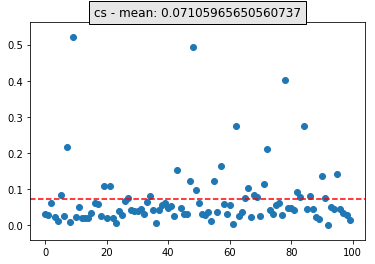

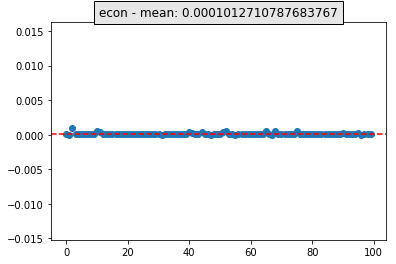

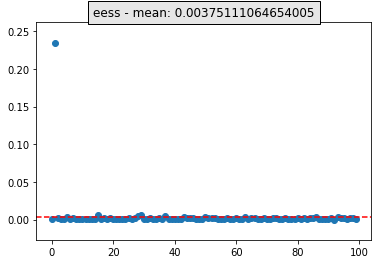

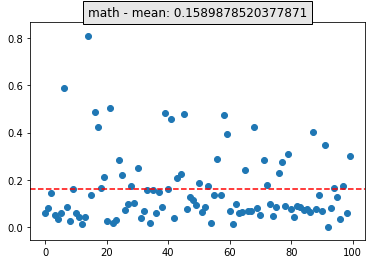

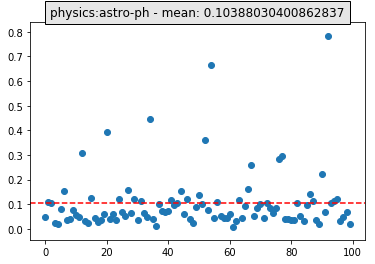

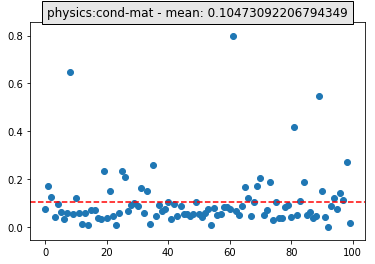

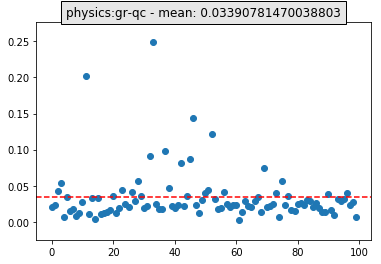

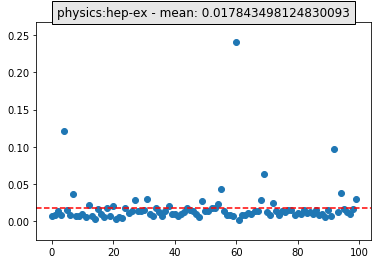

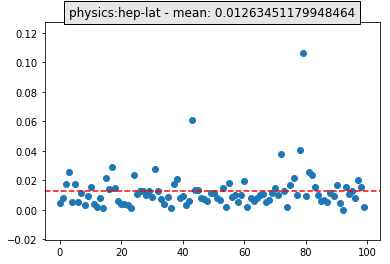

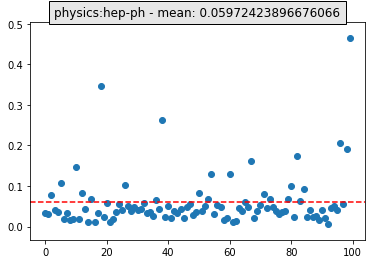

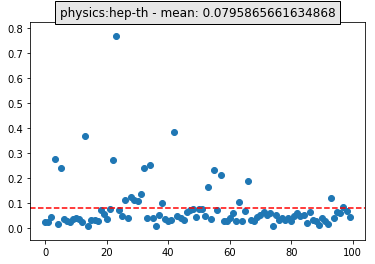

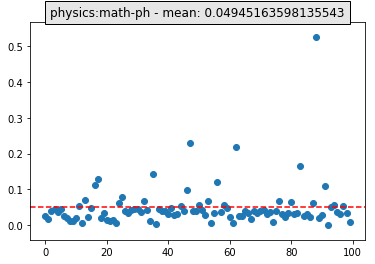

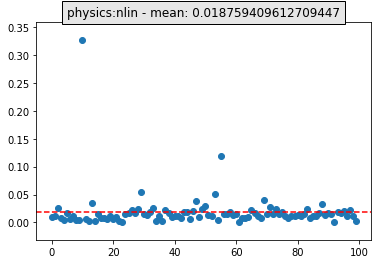

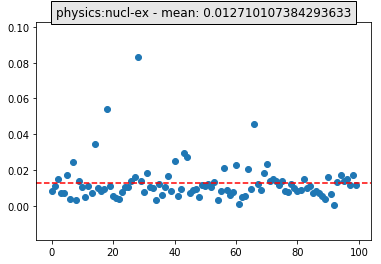

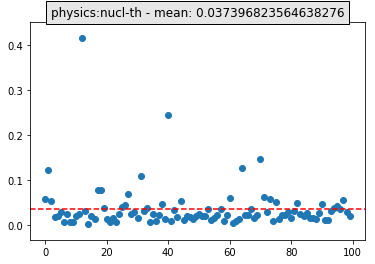

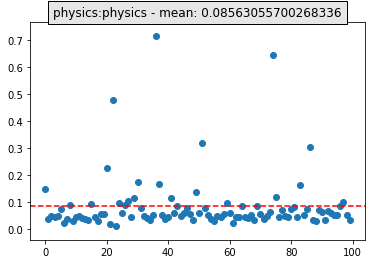

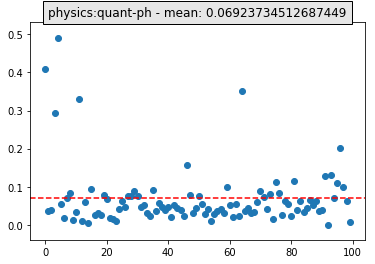

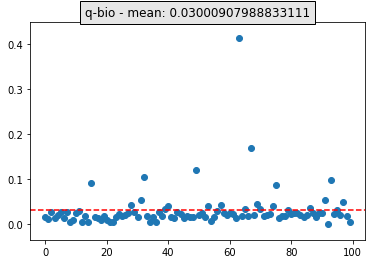

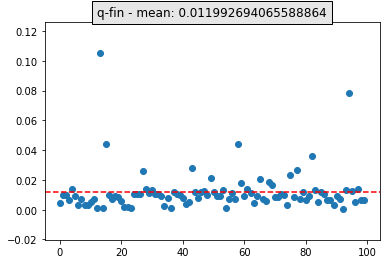

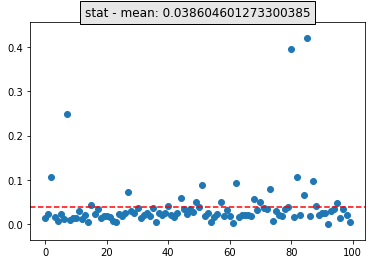

In [27]:
mean_funds_lst = []
for i in range(num_fields):
    y = [data[i] for data in best_field_funding_rec]
    y_mean = np.mean(y)
    mean_funds_lst.append(y_mean)
    plt.axhline(y = y_mean, color = 'r', linestyle = '--')
    plt.scatter(range(len(y)), y)
    plt.title(all_fields[i] + " - mean: " + str(y_mean), bbox={'facecolor': '0.9', 'pad': 5})
    plt.savefig(all_fields[i] + '.png')
    plt.show()

In [40]:
import math 
def round_sigfigs(num, sig_figs):
    """Round to specified number of sigfigs.

    >>> round_sigfigs(0, sig_figs=4)
    0
    >>> int(round_sigfigs(12345, sig_figs=2))
    12000
    >>> int(round_sigfigs(-12345, sig_figs=2))
    -12000
    >>> int(round_sigfigs(1, sig_figs=2))
    1
    >>> '{0:.3}'.format(round_sigfigs(3.1415, sig_figs=2))
    '3.1'
    >>> '{0:.3}'.format(round_sigfigs(-3.1415, sig_figs=2))
    '-3.1'
    >>> '{0:.5}'.format(round_sigfigs(0.00098765, sig_figs=2))
    '0.00099'
    >>> '{0:.6}'.format(round_sigfigs(0.00098765, sig_figs=3))
    '0.000988'
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0


In [43]:
mean_funds_lst_round = [round_sigfigs(data, 3) for data in mean_funds_lst]

In [48]:
mean_funds_lst1 = make_stochastic(np.array(mean_funds_lst_round))

In [54]:
mean_funds_lst1

array([7.10750527e-02, 1.00964561e-04, 3.74868421e-03, 1.58944211e-01,
       1.03963509e-01, 1.04963158e-01, 3.38881053e-02, 1.77937544e-02,
       1.25955790e-02, 5.96790527e-02, 7.95720702e-02, 4.94826316e-02,
       1.87934035e-02, 1.26955439e-02, 3.73868772e-02, 8.55699649e-02,
       6.91757193e-02, 2.99894737e-02, 1.19957895e-02, 3.85864562e-02])

In [69]:
pd.set_option('display.float_format', '{:.3g}'.format)
fund_dist_df = pd.DataFrame(mean_funds_lst1, index = all_fields, columns = ['Funding Portion'])
fund_dist_df.sort_values(by= ['Funding Portion'], ascending = False, inplace = True)


fund_dist_df.reset_index()

,index,Funding Portion
0,math,0.159
1,physics:cond-mat,0.105
2,physics:astro-ph,0.104
3,physics:physics,0.0856
4,physics:hep-th,0.0796
5,cs,0.0711
6,physics:quant-ph,0.0692
7,physics:hep-ph,0.0597
8,physics:math-ph,0.0495
9,stat,0.0386


In [70]:
f = open('latex.txt', 'w')
f.write(fund_dist_df.reset_index().to_latex())
f.close()

\\begin{tabular}{lr}\n\\toprule\n{} &  Funding Portion \\\\\n\\midrule\nmath             &            0.159 \\\\\nphysics:cond-mat &            0.105 \\\\\nphysics:astro-ph &            0.104 \\\\\nphysics:physics  &           0.0856 \\\\\nphysics:hep-th   &           0.0796 \\\\\ncs               &           0.0711 \\\\\nphysics:quant-ph &           0.0692 \\\\\nphysics:hep-ph   &           0.0597 \\\\\nphysics:math-ph  &           0.0495 \\\\\nstat             &           0.0386 \\\\\nphysics:nucl-th  &           0.0374 \\\\\nphysics:gr-qc    &           0.0339 \\\\\nq-bio            &             0.03 \\\\\nphysics:nlin     &           0.0188 \\\\\nphysics:hep-ex   &           0.0178 \\\\\nphysics:nucl-ex  &           0.0127 \\\\\nphysics:hep-lat  &           0.0126 \\\\\nq-fin            &            0.012 \\\\\neess             &          0.00375 \\\\\necon             &         0.000101 \\\\\n\\bottomrule\n\\end{tabular}\n

In [61]:
fund_dist_df

,Funding Portion
math,0.159
physics:cond-mat,0.105
physics:astro-ph,0.104
physics:physics,0.0856
physics:hep-th,0.0796
cs,0.0711
physics:quant-ph,0.0692
physics:hep-ph,0.0597
physics:math-ph,0.0495
stat,0.0386


In [5]:
import pandas as pd
from matplotlib import pyplot as plt

fun_dat = pd.read_csv('fun_data.csv')
fun_dat.head()

,cs,econ,eess,math,physics:astro-ph,physics:cond-mat,physics:gr-qc,physics:hep-ex,physics:hep-lat,physics:hep-ph,physics:hep-th,physics:math-ph,physics:nlin,physics:nucl-ex,physics:nucl-th,physics:physics,physics:quant-ph,q-bio,q-fin,stat
0,0.030825,0.000029,0.000663,0.058791,0.049499,0.072770,0.020901,0.006405,0.004939,0.034450,0.025821,0.025707,0.008972,0.008496,0.059387,0.150093,0.409020,0.015318,0.004467,0.013446
1,0.028625,0.000019,0.234806,0.080196,0.109844,0.170919,0.022824,0.008517,0.007711,0.029957,0.026296,0.016575,0.011587,0.011054,0.123780,0.037499,0.035166,0.011694,0.009669,0.023261
2,0.060744,0.001018,0.001703,0.143552,0.104028,0.126129,0.042812,0.013167,0.017364,0.077929,0.046067,0.038830,0.026339,0.015147,0.054292,0.048620,0.038972,0.025631,0.010153,0.107503
3,0.023107,0.000028,0.001067,0.049794,0.025353,0.040969,0.054095,0.008811,0.025439,0.041615,0.276668,0.043942,0.007997,0.007354,0.018253,0.045446,0.293249,0.013552,0.006747,0.016515
4,0.011575,0.000032,0.000247,0.034474,0.019822,0.094800,0.007261,0.121750,0.005659,0.035060,0.016897,0.035742,0.004397,0.007205,0.020865,0.051343,0.491637,0.019773,0.013939,0.007524


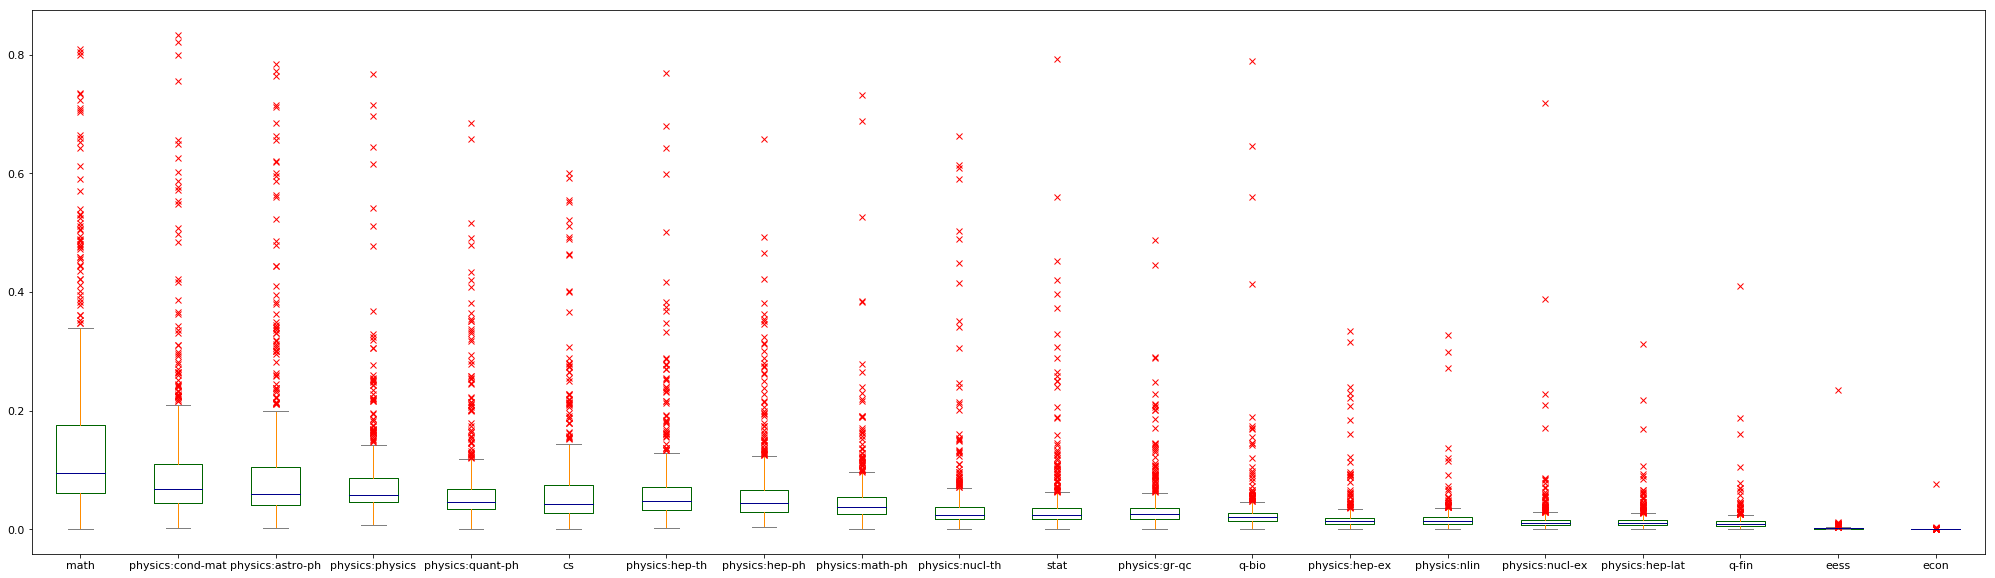

In [36]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')

fun_dat[['math', 'physics:cond-mat', 'physics:astro-ph', 'physics:physics',
       'physics:quant-ph', 'cs', 'physics:hep-th', 'physics:hep-ph',
       'physics:math-ph', 'physics:nucl-th', 'stat', 'physics:gr-qc', 'q-bio',
       'physics:hep-ex', 'physics:nlin', 'physics:nucl-ex', 'physics:hep-lat',
       'q-fin', 'eess', 'econ']].plot.box(figsize = (35,10), fontsize = 11, color=color, sym='rx')

plt.show()

In [29]:
mean_fun_dat = pd.DataFrame(fun_dat.describe().loc['mean'], columns = ['mean'])
mean_fun_dat.sort_values(by='mean', inplace = True, ascending = False)
mean_fun_dat.index

Index(['math', 'physics:cond-mat', 'physics:astro-ph', 'physics:physics',
       'physics:quant-ph', 'cs', 'physics:hep-th', 'physics:hep-ph',
       'physics:math-ph', 'physics:nucl-th', 'stat', 'physics:gr-qc', 'q-bio',
       'physics:hep-ex', 'physics:nlin', 'physics:nucl-ex', 'physics:hep-lat',
       'q-fin', 'eess', 'econ'],
      dtype='object')